Importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import gc
import copy
import nltk
import unicodedata
import itertools
import sklearn
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
emb_dim=300 #embedding dimension
batch_size=300 
hidden_size=128 # number of LSTM/GRU hidden units

Fixing random seeds:

In [3]:
def seed_everything(seed=42):
    #random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

Reading the data

In [4]:
train_df=pd.read_excel('../input/products/products.xlsx')
train_df.head()

,brand,category,condition,description,file_urls,files,id,image,name,price,shipping,url
0,NaN,Studio Recording Equipment,New,Audio interface new! Works with fire wire,https://static-mercariapp-com.akamaized.net/ph...,NaN,m46490058971,https://static-mercariapp-com.akamaized.net/ph...,Behringer AUDIO interface,$ 35.00,$6.00,https://item.mercari.com/gl/m46490058971/
1,NaN,Studio Recording Equipment,New,Focusrite Scarlett 2i4 USB Audio Interface (2n...,https://static-mercariapp-com.akamaized.net/ph...,NaN,m41956262411,https://static-mercariapp-com.akamaized.net/ph...,Focusrite Scarlett 2i4 USB Audio Interfa,$ 180.00,$6.00,https://item.mercari.com/gl/m41956262411/
2,Tascam,Studio Recording Equipment,Good,Original Price: $172.00 out of stock. Works pe...,https://static-mercariapp-com.akamaized.net/ph...,NaN,m48699763030,https://static-mercariapp-com.akamaized.net/ph...,Tascam US-144MKII Recording Interface,$ 34.00,$6.00,https://item.mercari.com/gl/m48699763030/
3,NaN,Studio Recording Equipment,Like New,Behringer Headphones HPS3000 high performance,https://static-mercariapp-com.akamaized.net/ph...,NaN,m41645959650,https://static-mercariapp-com.akamaized.net/ph...,Behringer Headphones HPS3000,$ 15.00,$6.00,https://item.mercari.com/gl/m41645959650/
4,Behringer,Studio Recording Equipment,Good,Behringer ULM100USB Ultralink USB Wireless Mic...,https://static-mercariapp-com.akamaized.net/ph...,NaN,m42480670580,https://static-mercariapp-com.akamaized.net/ph...,Behringer ULM100USB USB Microphone,$ 89.00,FREE,https://item.mercari.com/gl/m42480670580/


As shown below, the "Brand" column has a lot of NaN values so that it might not be useful for further computations.

In [5]:
train_df.brand.isna().value_counts()

True     8520
False    2608
Name: brand, dtype: int64

Selecting only the rows with not-NaN price.

In [6]:
train_df=train_df[train_df['price'].isna()==False]


As shown below, the only row that contains NaN values in "Category" and "Condition" columns is non-informative so we can safely drop it as well.

In [7]:
train_df[train_df.category.isna()]

,brand,category,condition,description,file_urls,files,id,image,name,price,shipping,url
2837,* The Calibration and Sound mode settings are ...,NaN,NaN,m91792620853,https://static-mercariapp-com.akamaized.net/ph...,Korg Chromatic Tuner,1554,$ 9.00,"$4.00, 3+ days",https://item.mercari.com/gl/m91792620853/,Other,Instrument Accessories


In [8]:
train_df[train_df.condition.isna()]

,brand,category,condition,description,file_urls,files,id,image,name,price,shipping,url
2837,* The Calibration and Sound mode settings are ...,NaN,NaN,m91792620853,https://static-mercariapp-com.akamaized.net/ph...,Korg Chromatic Tuner,1554,$ 9.00,"$4.00, 3+ days",https://item.mercari.com/gl/m91792620853/,Other,Instrument Accessories


In [9]:
train_df=train_df[train_df['condition'].isna()==False]

Converting the price to float type.

In [10]:
train_df.price=train_df['price'].str.strip().str.replace('$','').str.replace(',','')
train_df['price']=train_df.price.values.astype(float)

Visualizing the price by categories.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

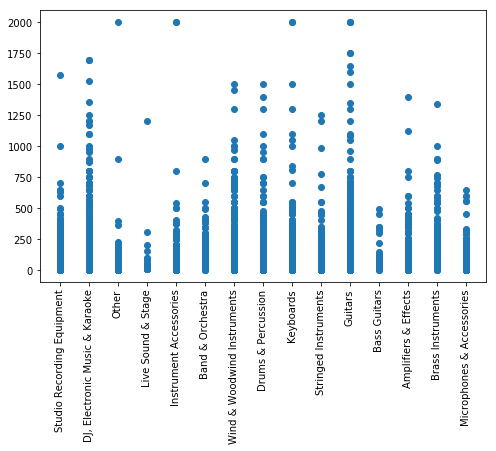

In [11]:
plt.figure(figsize=[8,5])
plt.scatter(train_df['category'],train_df['price'])
plt.xticks( rotation='vertical')

From the box plot below we can see that there is a lot of outliers in the data. However, if we remove all them, we might lose a lot of useful information, so I tried two options: removing all outliers (examples with price>(Q3 + 3* IQR)) and removing only certain outliers and keeping others.

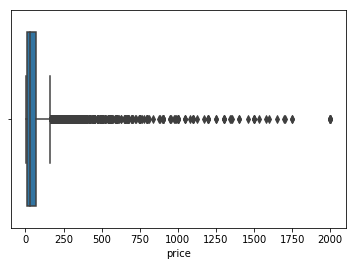

In [12]:
sns.boxplot(train_df['price'])

In [13]:
Q1 = train_df.price.quantile(0.25)
Q3 = train_df.price.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

60.0


In [14]:
train_df_out = train_df[~(train_df.price > (Q3 + 3* IQR))]
train_df_out.shape

(10504, 12)

In [15]:
max(train_df_out.price)

252.0

Setting remove_all_outliers=False - to remove only certain outliers.

In [16]:
remove_all_outliers=False
if remove_all_outliers:
    train_df=train_df_out
else:
    train_df=train_df[train_df.price<2000]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

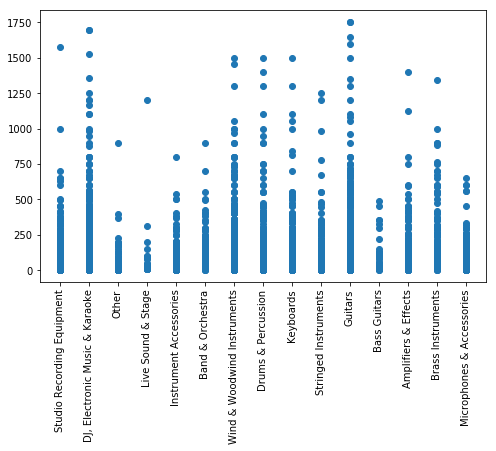

In [17]:
plt.figure(figsize=[8,5])
plt.scatter(train_df['category'],train_df['price'])
plt.xticks( rotation='vertical')

In [18]:
if not remove_all_outliers:
    train_df=train_df.drop(train_df.index[(train_df.price>750)&(train_df.category=='Other')])
    train_df=train_df.drop(train_df.index[(train_df.price>1500)&(train_df.category=='Studio Recording Equipment')])
    train_df=train_df.drop(train_df.index[(train_df.price>1000)&(train_df.category=='Live Sound & Stage')])

Visualizing the data after removing outliers.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

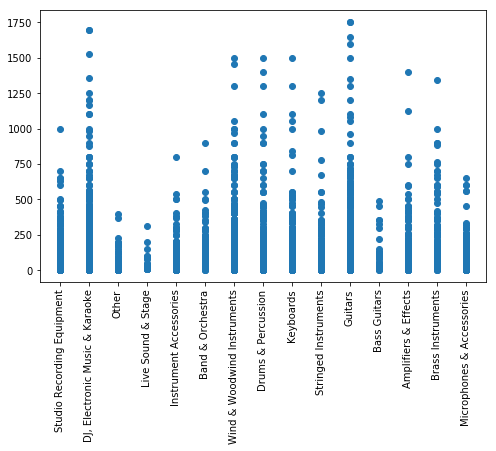

In [19]:
plt.figure(figsize=[8,5])
plt.scatter(train_df['category'],train_df['price'])
plt.xticks( rotation='vertical')

Saving original dataframe- for further error analysis.

In [20]:
train_df_original=train_df[['description','category','condition','price']]

Converting the values from "Condition" and "Category" columns to One-hot format to later use them as inputs for final meta-model.

In [21]:
X_cond_cat=np.column_stack((pd.get_dummies(train_df['category']).values,
                            pd.get_dummies(train_df['condition']).values))

Some statistics for train_df.

In [22]:
train_df.describe()

,price
count,11110.000000
mean,70.875248
std,132.219433
min,3.000000
25%,12.000000
50%,30.000000
75%,70.750000
max,1750.000000


Defining the Contraction mapping dictionary and the misprints dictionary.

In [23]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
                       "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                       "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                       "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have",
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                       "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                       "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                       "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                       "where'd": "where did", "where's": "where is", "where've": "where have", 
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are",
                       "you've": "you have"}
misprint_dict={"microhone": "microphone", "microphone1": "microphone", 
                       "usedlike": "used like", "comesith": "comes with", "audiobox": "audio box","greattt":"great",
                      "mcrophone": "microphone","neewer": "newer","newhigh": "new high","boxnever": "box never",
                      'newgreat':"new great","newused": "new used", 'audiointerface': 'audio interface',
                      "feelree": "feel free", 'oncecomes':"once comes", "condiion": "condition",
                      'inclded':'included','recrding':'recording','mirophone':'microphone',
                       'microphonecomes':'microphone comes','microphonegreat': 'microphone great','newfree':'new free',
                      'recordgreat':'record great','oriinal':'original','conditioncomes':'condition comes',
                      'originaprice': 'original price','inxcellent':'excellent','handlesmeasurements':
                      'handles measurements','picturehas':'picture has','favorites®':'favorites',
                       'perfectlyi':'perfectly','beginnersincludes':'beginners includes','drawngs':'drawings',
                      'microphone.':'microphone','includedcomes':'included comes', 
                       'conditin':'condition','boxcomes':'box comes','shippingjem':'shipping','mount1':'mount',
                      'perfectondition':'perfect condition','shippingprice':'shipping price',
                      'newstill':'new still','boxgreat':'box great','neverused':'never used','newnever':'new never',
                      'usedoriginally':'used originally','micbluetooth':'microphone bluetooth',
                       'conditionused':'condition used','guitarcomes':'guitar comes',
                       'conditionincludes':'condition includes','usethem':'use them','sounand':'sound',
                       'guitarbook':'guitar book','newfeatures':'new features','conditioncomes':'condition comes',
                      'evrything':'everything','mic':'microphone', 'packagecondenser':'package condenser',
                        'microphoneused':'microphone used','standcordsinterface': 'standard cord interface',
               'botha':'both','microphonemic':'microphone','US-122mkII':'','iionnects':'connects'}

Defining the functions for cleaning, tokenizing and lemmatizing the data.

In [24]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
specials = ["’", "‘", "´", "`"]
def unicodeToAscii(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn')

def clean_text(text,contraction_mapping=contraction_mapping,misprint_mapping=misprint_dict,punct=punct,
               specials=specials):
    text=unicodeToAscii(text.strip())
    text=text.encode('ascii', 'ignore').decode("utf-8")
    text=' '.join(re.findall('[A-Z]*[^A-Z]*', text)) 
    for char in specials:
        text=text.replace(char,"‘")
    text=' '.join([contraction_mapping[t] if t in contraction_mapping.keys() else t for t in text.lower().split(' ')])
    text=''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    for sym in punct:
            text=text.replace(sym,' ')
    text=' '.join([misprint_mapping[t] if t in misprint_mapping.keys() else t for t in text.split(' ')])
    return text
    


In [25]:
def tokenize(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    text = tokenizer.tokenize(text)
    return text

stop_words=stopwords.words('english')

def remove_stop_words(word_list,stop_words=stop_words):
    return([word for word in word_list if word not in stop_words])

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(word_list,lemmatizer=lemmatizer):
    return [lemmatizer.lemmatize(word) for word in word_list]
    
def preprocess(text):
    text=clean_text(text)
    text=tokenize(text)
    text=remove_stop_words(text)
    text=lemmatize(text)
    return text


Preprocessing data.

In [26]:
train_df['description']=train_df['description'].astype(str).apply(lambda x: preprocess(x))
train_df['condition']=train_df['condition'].astype(str).apply(lambda x: preprocess(x))
train_df['category']=train_df['category'].astype(str).apply(lambda x: preprocess(x))
train_df['name']=train_df['name'].astype(str).apply(lambda x: preprocess(x))

In [27]:
train_df['description'][:10]

0            [audio, interface, new, work, fire, wire]
1    [focusrite, scarlett, 2i4, usb, audio, interfa...
2    [original, price, 172, 00, stock, work, perfec...
3    [behringer, headphone, hps300, high, performance]
4    [behringer, ulm100, usb, ultralink, usb, wirel...
5    [brand, new, package, condenser, microphone, t...
6    [three, wildly, popular, alabama, album, great...
7    [great, usb, midi, pad, controller, barely, us...
8    [digidesign, mbox, 2, usb, digital, audio, int...
9                     [bought, never, used, like, new]
Name: description, dtype: object

Defining the class to build vocabulary

In [28]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
EOS_token = 1  # End-of-sentence token

class Voc:
    def __init__(self):
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", EOS_token: "EOS"}
        self.num_words = 2  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", EOS_token: "EOS"}
        self.num_words = 2 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Putting the values from "Condition", "Category", "Description" and "Name" columns into a single column for further computations.

In [29]:
array_all=np.empty(len(train_df['description']))
array_all=[train_df['condition'].values[i]+train_df['category'].values[i]+
          train_df['description'].values[i]+train_df['name'].values[i] for i in range(len(train_df['description']))]

In [30]:
array_all[:10]

[['new',
  'studio',
  'recording',
  'equipment',
  'audio',
  'interface',
  'new',
  'work',
  'fire',
  'wire',
  'behringer',
  'audio',
  'interface'],
 ['new',
  'studio',
  'recording',
  'equipment',
  'focusrite',
  'scarlett',
  '2i4',
  'usb',
  'audio',
  'interface',
  '2nd',
  'generation',
  'picture',
  'thectual',
  'item',
  'receive',
  'brand',
  'new',
  'focusrite',
  'scarlett',
  '2i4',
  'usb',
  'audio',
  'interfa'],
 ['good',
  'studio',
  'recording',
  'equipment',
  'original',
  'price',
  '172',
  '00',
  'stock',
  'work',
  'perfect',
  'problem',
  'u',
  '122mk',
  'connects',
  'mac',
  'window',
  'computer',
  'using',
  'usb',
  '2',
  '0',
  'unit',
  'powered',
  'usb',
  'cable',
  'zero',
  'latency',
  'monitoring',
  'available',
  'recording',
  'without',
  'delay',
  'going',
  'computer',
  'back',
  'midi',
  'input',
  'output',
  'jack',
  'allow',
  'connection',
  'synths',
  'drum',
  'machine',
  'connect',
  'u',
  '122mk',
  

Building vocabulary

In [31]:
voc=Voc()
for sentence in array_all:
    voc.addSentence(sentence)

Defining the functions to load embeddings and build embedding matrix.

In [32]:

def get_coeffs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
def load_embeddings(path):
    f=open(path)
    return(dict(get_coeffs(*line.strip().split(' ')) for line in tqdm(f)))
def build_matrix(emb_dict,voc):
    unknown_words=[]
    embedding_matrix=np.zeros((len(voc.word2index)+2,emb_dim))
    for word,i in voc.word2index.items():
           try:
                embedding_matrix[i]=emb_dict[word]
           except KeyError:
                unknown_words.append(word)
    return(embedding_matrix, unknown_words)

Loading pre-trained embeddings and building embedding matrix.

In [33]:
path='../input/glove840b300dtxt/glove.840B.300d.txt'
emb_dict=load_embeddings(path)
emb_matrix,unk_words=build_matrix(emb_dict,voc)
del emb_dict
gc.collect()

0

The number of unknown words:

In [34]:
len(unk_words)

5025

The list of unknown words.

In [35]:
unk_words

['2i4',
 'thectual',
 '122mk',
 'hps300',
 'ulm100',
 'ultralink',
 'mpd18',
 'interface24',
 'samplng',
 'functionall',
 'dmp3',
 'umc22',
 'ab1818',
 'ab1818vsl',
 'phantopowered',
 'anmicrophone',
 'itsother',
 'ramge',
 'at4047',
 'qualitis',
 'v67g',
 'boomarm',
 'pylepro',
 'canlso',
 'padkontrol',
 'thaas',
 'paintork',
 'smgk',
 'mbox2',
 'storand',
 'includemostly',
 'country60s',
 'speakers2',
 'controllerith',
 'wpower',
 'vserial',
 '13007132',
 'onale',
 'ttusbo5',
 'turtable',
 'bndle',
 'alln',
 'xenyx502',
 '1274115052025',
 'lpd8',
 'amazingondition',
 'microphond',
 'ofear',
 'makala',
 'electronicdrum',
 'lssons',
 'hohnica',
 'color25',
 'buttons2',
 'q502',
 'compatiblewithout',
 'withore',
 'b205',
 'protools0',
 '10hd',
 'prined',
 'scratchesn',
 'focuscrite',
 'for0',
 'qualitprofessional',
 'bx5s',
 'muicians',
 'mpd226',
 'lpk25',
 'areerfect',
 'senal',
 'boardwith',
 'recordingoftwares',
 'havno',
 'fromstore',
 'volca',
 'andreview',
 'wxf',
 'yew6zw',
 'po

Defining the functions to convert sentences to torch tensors.

In [36]:
def indexesFromSentence(voc,sentence):
    indices=[]
    for word in sentence:
        try: 
            indices.append(voc.word2index[word])
        except KeyError:
            continue
    return indices        
        
def tensorFromSentence(voc,sentence):
    indexes=indexesFromSentence(voc,sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes,dtype=torch.long).cuda().view(-1,1)

Converting input sentences to tensors.

In [37]:
input_tensors=[]
for i,sentence in enumerate(array_all):
    input_tensors.append(tensorFromSentence(voc,sentence))
input_tensors=np.array(input_tensors)    


Splitting input tensors and targets into train and test split, as well as original indices (for error analysis).

In [38]:
y=train_df['price'].values
indices=np.arange(len(train_df['price'].values))
bins = np.linspace(0, max(y)+1, 10)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(input_tensors, y, test_size=0.1, stratify=y_binned,random_state=1)
indices_train_val,indices_test,_,_= train_test_split(indices, y, test_size=0.1, stratify=y_binned,random_state=1)
X_cond_train, X_cond_test,_, _ = train_test_split(X_cond_cat, y, test_size=0.1, stratify=y_binned,random_state=1)


Splitting the training data into 5 splits using Stratified Kfold.

In [39]:
input_tensors_train={}
input_tensors_val={}
target_tensors_train={}
target_tensors_val={}
X_cond_val={}
i=0

input_tensors_train_val=X_train
input_tensors_test=X_test
target_tensors_train_val=torch.tensor(y_train,dtype=torch.float32).cuda()
target_tensors_test=torch.tensor(y_test,dtype=torch.float32).cuda()
y_train_binned = np.digitize(y_train, bins)

kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
for train_index, test_index in kf.split(input_tensors_train_val, y_train_binned):
    input_tensors_train[i]=input_tensors_train_val[train_index]
    input_tensors_val[i]=input_tensors_train_val[test_index]
    target_tensors_train[i]=target_tensors_train_val[train_index]
    target_tensors_val[i]=target_tensors_train_val[test_index]
    X_cond_val[i]=X_cond_train[test_index]
    i+=1

Defining the class to represent sentence dataset

In [40]:
class SentenceDataset(data.Dataset):
    def __init__(self,inputs,targets):
        super().__init__()
        self.inputs=inputs
        self.targets=targets
    def __len__(self):
        return(len(self.inputs))
    def __getitem__(self,idx):
        return (self.inputs[idx],self.targets[idx])
        

Defining 5 training, 5 validation datasets and test dataset.

In [41]:
sentences_train={}
for i in range(kf.get_n_splits()):
    sentences_train[i]=SentenceDataset(input_tensors_train[i],target_tensors_train[i])
sentences_val={}
for i in range(kf.get_n_splits()):
    sentences_val[i]=SentenceDataset(input_tensors_val[i],target_tensors_val[i])
sentences_test=SentenceDataset(input_tensors_test,target_tensors_test)    
    

Modifying the built-in torch pad_sequence function to work with 

In [42]:
def pad_sequence(pair_sequence_target, batch_first=True, padding_value=0):
    r"""Pad a list of variable length Tensors with ``padding_value``

    ``pad_sequence`` stacks a list of Tensors along a new dimension,
    and pads them to equal length. For example, if the input is list of
    sequences with size ``L x *`` and if batch_first is False, and ``T x B x *``
    otherwise.

    `B` is batch size. It is equal to the number of elements in ``sequences``.
    `T` is length of the longest sequence.
    `L` is length of the sequence.
    `*` is any number of trailing dimensions, including none.

    Example:
        >>> from torch.nn.utils.rnn import pad_sequence
        >>> a = torch.ones(25, 300)
        >>> b = torch.ones(22, 300)
        >>> c = torch.ones(15, 300)
        >>> pad_sequence([a, b, c]).size()
        torch.Size([25, 3, 300])

    Note:
        This function returns a Tensor of size ``T x B x *`` or ``B x T x *``
        where `T` is the length of the longest sequence. This function assumes
        trailing dimensions and type of all the Tensors in sequences are same.

    Arguments:
        sequences (list[Tensor]): list of variable length sequences.
        batch_first (bool, optional): output will be in ``B x T x *`` if True, or in
            ``T x B x *`` otherwise
        padding_value (float, optional): value for padded elements. Default: 0.

    Returns:
        Tensor of size ``T x B x *`` if :attr:`batch_first` is ``False``.
        Tensor of size ``B x T x *`` otherwise
    """

    # assuming trailing dimensions and type of all the Tensors
    # in sequences are same and fetching those from sequences[0]
#     batches=[]
    batch_input=[]
    batch_output=[]
    outputs=[]

    for j in range(len(pair_sequence_target)):
       
        batch_input.append(pair_sequence_target[j][0])
        batch_output.append(pair_sequence_target[j][1])

#         sequences=
    sequences=batch_input

    max_size = sequences[0].size()
    trailing_dims = max_size[1:]
    max_len = max([s.size(0) for s in sequences])
    if batch_first:
        out_dims = (len(sequences), max_len) + trailing_dims
    else:
        out_dims = (max_len, len(sequences)) + trailing_dims

    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_value)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        # use index notation to prevent duplicate references to the tensor
        if batch_first:
            out_tensor[i, :length, ...] = tensor
        else:
            out_tensor[:length, i, ...] = tensor
    out_tensor=out_tensor.squeeze(2)
    outputs.append(out_tensor)
    target_tensor=torch.tensor(batch_output,dtype=torch.float32).cuda().unsqueeze(1)
    outputs.append(target_tensor)
    return tuple(outputs)#out_tensor

Defining train and validation dataloaders for each of 5 splits and the test dataloader 
sentence_loader_val1 is the same as validation dataloader but without shuffle - it's used to make final model predictions on validation splits to further feed them to meta-model.


In [43]:
sentence_loader_train={}
for i in range(kf.get_n_splits()):
    sentence_loader_train[i]=torch.utils.data.DataLoader(sentences_train[i],batch_size=batch_size,shuffle=True,
                                                          collate_fn=pad_sequence,
                                                         drop_last=False)
sentence_loader_val={}
for i in range(kf.get_n_splits()):
    sentence_loader_val[i]=torch.utils.data.DataLoader(sentences_val[i],batch_size=batch_size,shuffle=True,
                                                 collate_fn=pad_sequence,
                                                       drop_last=False)
sentence_loader_val1={}
for i in range(kf.get_n_splits()):
    sentence_loader_val1[i]=torch.utils.data.DataLoader(sentences_val[i],batch_size=batch_size,shuffle=False,
                                                   collate_fn=pad_sequence,
                                                        drop_last=False)    
sentence_loader_test=torch.utils.data.DataLoader(sentences_test,batch_size=batch_size,shuffle=False,
                                                   collate_fn=pad_sequence,
                                                        drop_last=False)    

Building 2 models: 2-layer LSTM+Attention weights and 1-layer LSTM.

In [44]:
class LSTM_Attn(nn.Module):
    def __init__(self,hidden_size,emb_matrix):
        super().__init__()
        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(*emb_matrix.shape)
        self.embedding.weight=nn.Parameter(torch.tensor(emb_matrix,
                                                        dtype=torch.float32).cuda())
        self.embedding.weight.requires_grad=False
        self.dropout = nn.Dropout2d(0.1)
        self.lstm1=nn.LSTM(emb_dim,hidden_size,batch_first=True, bidirectional=True)
        self.lstm2=nn.LSTM(hidden_size*2,int(hidden_size/2),batch_first=True,bidirectional=True)
        self.attn=nn.Linear(hidden_size,1)
        self.linear=nn.Linear(hidden_size,hidden_size)
        self.out=nn.Linear(hidden_size,1)
    def forward(self, input):
        embedded=self.embedding(input)
        output=embedded
        output,_=self.lstm1(output)
        output,_=self.lstm2(output)
        score = torch.tanh(self.attn(output)).squeeze(2)
        attn_weights=F.softmax(score,dim=1).unsqueeze(1)
        context=torch.bmm(attn_weights,output)
        context = context.squeeze(1)
        output=torch.relu(self.linear(context))
        output=self.out(output)
        return output


In [45]:
class LSTM(nn.Module):
    
    def __init__(self,hidden_size,emb_matrix):
        super().__init__()
        self.hidden_size = hidden_size
        drp = 0.1
        self.embedding = nn.Embedding(*emb_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(emb_dim, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , int(self.hidden_size/2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(int(self.hidden_size/2), 1)


    def forward(self, x):
        embedded = self.embedding(x)
        embedded = torch.squeeze(torch.unsqueeze(embedded, 0))       
        lstm, _ = self.lstm(embedded)
        avg_pool = torch.mean(lstm, 1)
        max_pool, _ = torch.max(lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        output = self.out(conc)
        return output


Defining One-Cycle scheduler.

In [46]:
class OneCycleScheduler(object):
    def __init__(self, optimizer, lr, beta, max_steps, annealing):
        self.optimizer = optimizer
        self.lr = lr
        self.beta = beta
        self.max_steps = max_steps
        self.annealing = annealing
        self.epoch = -1
    
    def step(self):
        self.epoch += 1
        
        mid = round(self.max_steps * 0.3)
        if self.epoch < mid:
            r = self.epoch / mid
            lr = self.annealing(self.lr[0], self.lr[1], r)
            beta = self.annealing(self.beta[0], self.beta[1], r)
        else:
            r = (self.epoch - mid) / (self.max_steps - mid)
            lr = self.annealing(self.lr[1], self.lr[0] / 1e4, r)
            beta = self.annealing(self.beta[1], self.beta[0], r)

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            param_group['betas'] = (beta, *param_group['betas'][1:])

def annealing_linear(start, end, r):
    return start + r * (end - start)            
            
def annealing_cos(start, end, r):
    cos_out = np.cos(np.pi * r) + 1
    return end + (start - end) / 2 * cos_out 

Defining the function to train the model.

In [47]:

def train_model_kf(Model,hidden_size,emb_matrix,kf,sentence_loader_train,sentence_loader_val,criterion,
                   optimizer,scheduler,num_epochs,clip,min_lr=1e-5,max_lr=0.01):
    train_losses={}
    val_losses={}
    best_val_loss={}
    best_model_wts={}
    
    for i in range(kf.get_n_splits()):
        model=Model(hidden_size,emb_matrix).cuda()
        opt=optimizer(model.parameters(),lr=max_lr)
        sched = scheduler(opt, lr=(min_lr, max_lr), beta=(0.9, 0.8),
                                max_steps=(num_epochs)*len(sentence_loader_train[i]), annealing= annealing_linear)

        best_val_loss[i]=1e+10
        val_losses[i]=np.zeros(num_epochs)
        train_losses[i]=np.zeros(num_epochs)
        print('split:',i)
        for epoch in range(num_epochs):
            loss_epoch=0
            print('Epoch:', epoch)
            with torch.set_grad_enabled(True):
                model.train()
                for input_tensor,target in sentence_loader_train[i]:
                    sched.step()
                    output=model(input_tensor)
                    loss=criterion(output,target)
                    opt.zero_grad()
                    loss.backward()
                    _ = nn.utils.clip_grad_norm_(model.parameters(), clip)
                    opt.step()
                    loss_epoch+=loss.item()                

                loss_epoch/=len(sentence_loader_train[i])
                print('train loss=',loss_epoch)
                train_losses[i][epoch]=loss_epoch
            with torch.no_grad():
                model.eval()
                for input_tensor,target in sentence_loader_val[i]:
                    output=model(input_tensor)
                    loss=criterion(output,target)
                    loss_epoch+=loss.item()
                loss_epoch/=len(sentence_loader_val[i])
                val_losses[i][epoch]=loss_epoch
                if (loss_epoch<best_val_loss[i]):
                    best_val_loss[i]=loss_epoch
                    best_model_wts[i] = copy.deepcopy(model.state_dict())  
                print('val loss=',loss_epoch)
        print('best val loss',best_val_loss[i])
        losses={'train':train_losses,'val':val_losses}
    return (best_model_wts,best_val_loss,losses)        

Training 2 models: LSTM and LSTM+Attention for 50 epochs using One-Cycle scheduler.

In [48]:
num_epochs=50
clip=50
criterion=nn.MSELoss()
opt=torch.optim.Adam
scheduler = OneCycleScheduler
best_model_wts1,best_val_loss1,losses1=train_model_kf(LSTM_Attn,hidden_size,emb_matrix,kf,sentence_loader_train,
                        sentence_loader_val,criterion,opt,scheduler,num_epochs,clip)
best_model_wts2,best_val_loss2,losses2=train_model_kf(LSTM,hidden_size,emb_matrix,kf,sentence_loader_train,
                        sentence_loader_val,criterion,opt,scheduler,num_epochs,clip)


split: 0
Epoch: 0
train loss= 21846.096160888672
val loss= 26637.323543548584
Epoch: 1
train loss= 19932.49878692627
val loss= 23605.909516334534
Epoch: 2
train loss= 17142.1808013916
val loss= 20892.22847175598
Epoch: 3
train loss= 16732.997161865234
val loss= 21033.160900115967
Epoch: 4
train loss= 17416.39060974121
val loss= 21043.423093795776
Epoch: 5
train loss= 16399.308349609375
val loss= 20770.473724365234
Epoch: 6
train loss= 15765.771728515625
val loss= 18650.954681396484
Epoch: 7
train loss= 15678.283706665039
val loss= 18753.88507270813
Epoch: 8
train loss= 14309.417266845703
val loss= 18141.721836090088
Epoch: 9
train loss= 15162.273132324219
val loss= 18523.411094665527
Epoch: 10
train loss= 13523.939392089844
val loss= 16920.416191101074
Epoch: 11
train loss= 12032.340301513672
val loss= 15453.07799911499
Epoch: 12
train loss= 11140.270385742188
val loss= 14908.221603393555
Epoch: 13
train loss= 10164.206726074219
val loss= 15081.5316696167
Epoch: 14
train loss= 9271.095

Averaged best MSE on validation splits for the first model.

In [49]:
sum(list(best_val_loss1.values()))/kf.get_n_splits()

11692.604544049502

Averaged best MSE on validation splits for the second model.

In [50]:
sum(list(best_val_loss2.values()))/kf.get_n_splits()

11742.4366738379

Plotting the losses for both models for every split.

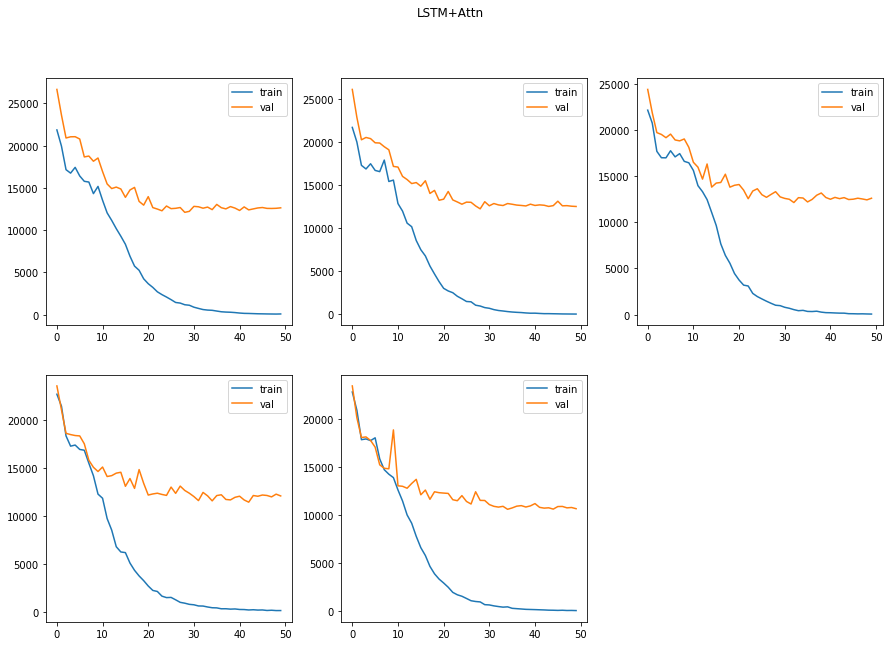

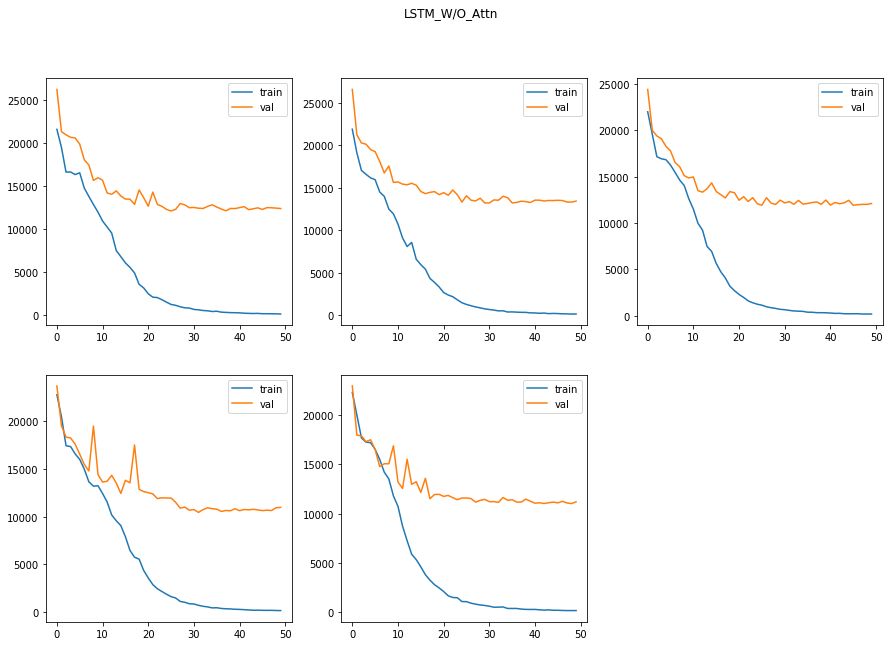

In [51]:
plt.figure(figsize=[15,10])
for i in range(kf.get_n_splits()):
    plt.subplot(2,3,i+1)
    plt.plot(np.arange(num_epochs),losses1['train'][i],label='train')
    plt.plot(np.arange(num_epochs),losses1['val'][i],label='val')
    plt.legend()
plt.suptitle('LSTM+Attn')    
plt.show()
plt.figure(figsize=[15,10])
for i in range(kf.get_n_splits()):
    plt.subplot(2,3,i+1)
    plt.plot(np.arange(num_epochs),losses2['train'][i],label='train')
    plt.plot(np.arange(num_epochs),losses2['val'][i],label='val')
    plt.legend()
plt.suptitle('LSTM_W/O_Attn')    
plt.show()

Loading the weights for the models trained on 5 splits.

In [52]:
models1={}
for i in range(kf.get_n_splits()):
    models1[i]=LSTM_Attn(hidden_size,emb_matrix).cuda()
    models1[i].load_state_dict(best_model_wts1[i])
    

models2={}
for i in range(kf.get_n_splits()):
    models2[i]=LSTM(hidden_size,emb_matrix).cuda()
    models2[i].load_state_dict(best_model_wts2[i])

Making predictions on validation splits for each model to use them as training data for final meta-model.

In [53]:
targets_val=target_tensors_val
predictions_val1={}

for i in range(kf.get_n_splits()):
    predictions_val1[i]=np.zeros(len(input_tensors_val[i]))
    j=0
    for inputs,targets in sentence_loader_val1[i]:
        models1[i].eval()
        with torch.no_grad():
            preds_val=models1[i](inputs)
            for m in range(preds_val.shape[0]):
                predictions_val1[i][j]= abs(preds_val.unsqueeze(1).cpu().detach().numpy()[m])
                j+=1
        


predictions_val2={}
for i in range(kf.get_n_splits()):
    predictions_val2[i]=np.zeros(len(input_tensors_val[i]))
    j=0
    for inputs,targets in sentence_loader_val1[i]:
        models2[i].eval()
        with torch.no_grad():
            preds_val=models2[i](inputs)
            for m in range(preds_val.shape[0]):
                predictions_val2[i][j]= abs(preds_val.unsqueeze(1).cpu().detach().numpy()[m])
                j+=1
        


Making predictions on test dataset for each model to use them as test data for final meta-model.

In [54]:
predictions_test1={}
predictions_test2={}
for i in range(kf.get_n_splits()):
    predictions_test1[i]=np.zeros(len(input_tensors_test))
    predictions_test2[i]=np.zeros(len(input_tensors_test))
    j=0
    for inputs,targets in sentence_loader_test:
        models1[i].eval()
        models2[i].eval()
        with torch.no_grad():
            preds_test1=models1[i](inputs)
            preds_test2=models2[i](inputs)
            for m in range(targets.shape[0]):
                predictions_test1[i][j]= abs(preds_test1.unsqueeze(1).cpu().detach().numpy()[m])
                predictions_test2[i][j]= abs(preds_test2.unsqueeze(1).cpu().detach().numpy()[m])
                j+=1

In [55]:
def normalize(x):
    return (x-x.mean(axis=0))/x.std(axis=0)

Stacking predictions on validation splits into one column for each model and adding the categorical variables (condition and category). So the training dataset for the final model will contain 22 columns: 20 categorical variables (15 condition and 5 category) and 2 columns of predictions on the training data for both models.

In [56]:
x_train1=[]
x_train2=[]
y_train=[]
X_cond=np.zeros(X_cond_train.shape)
j=0
for i in range(kf.get_n_splits()):
    x_train1.extend(predictions_val1[i])
    X_cond[j:j+len(X_cond_val[i]),:]=X_cond_val[i]
    j+=len(X_cond_val[i])
    y_train.extend(targets_val[i])
for i in range(kf.get_n_splits()): 
    x_train2.extend(predictions_val2[i])
    

x_train1=np.array(x_train1)
x_train2=np.array(x_train2)
y_train=np.array(y_train)
x_train=np.column_stack((X_cond,normalize(x_train1),normalize(x_train2)))

Averaging predictions on test dataset for each model.
Stacking these predictions and adding the categorical variables for test data (condition and category).
So the test dataset for the final model will contain 22 columns, same as the training dataset.

In [57]:
y_test=np.array([target.detach().cpu().numpy() for target in target_tensors_test])
x_test1=predictions_test1[0]
x_test2=predictions_test2[0]
y_test=np.array([target.detach().cpu().numpy() for target in target_tensors_test])
for i in range(kf.get_n_splits()-1):
    x_test1+=predictions_test1[i+1]
    x_test2+=predictions_test2[i+1]
x_test1/=kf.get_n_splits()
x_test2/=kf.get_n_splits()

x_test=np.column_stack((X_cond_test,normalize(x_test1),normalize(x_test2)))

Fitting 2 meta-models on the final training data: the linear regression model and xgboost.

In [58]:
lin_regr=LinearRegression(normalize=True)
xgb_regr=xgb.XGBRegressor(n_estimators=30,max_depth=4,lr=0.1, booster='gbtree',min_samples_leaf=4)
lin_regr.fit(x_train,y_train)
xgb_regr.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, lr=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, min_samples_leaf=4, missing=None,
       n_estimators=30, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Making predictions on test data using both meta-models, then averaging them.
Printing R^2 values for each meta-model and averaged model.

In [59]:
y_hat_test1=xgb_regr.predict(x_test)
y_hat_test2=lin_regr.predict(x_test)
y_hat_test=(y_hat_test2+y_hat_test1)/2
print('R2 for xgboost: ',r2_score(y_test,y_hat_test1))
print('R2 for lin reg: ',r2_score(y_test,y_hat_test2))
print('R2 for combined model: ',r2_score(y_test,y_hat_test))
print('Median of absolute error: ',np.median(abs(y_hat_test-y_test)))

R2 for xgboost:  0.4460916495510646
R2 for lin reg:  0.41915629685759803
R2 for combined model:  0.43911428539686015
Median of absolute error:  18.50071907043457


Plotting the histogram of absolute errors on test data.

(array([830., 142.,  55.,  28.,  18.,  10.,   6.,   7.,   4.,   3.,   1.,
          0.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([2.75115967e-02, 4.43542605e+01, 8.86810094e+01, 1.33007758e+02,
        1.77334507e+02, 2.21661256e+02, 2.65988005e+02, 3.10314754e+02,
        3.54641503e+02, 3.98968252e+02, 4.43295001e+02, 4.87621750e+02,
        5.31948499e+02, 5.76275247e+02, 6.20601996e+02, 6.64928745e+02,
        7.09255494e+02, 7.53582243e+02, 7.97908992e+02, 8.42235741e+02,
        8.86562490e+02, 9.30889239e+02, 9.75215988e+02, 1.01954274e+03,
        1.06386949e+03, 1.10819623e+03, 1.15252298e+03, 1.19684973e+03,
        1.24117648e+03, 1.28550323e+03, 1.32982998e+03]),
 <a list of 30 Patch objects>)

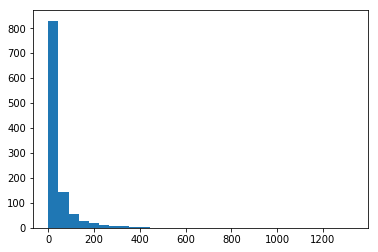

In [60]:
plt.hist(abs(y_hat_test-y_test),bins=30)

Predicted and true values with largest absolute errors. Most of true values with largest errors are over 700, so they are in outliers zone.

In [61]:
np.column_stack((y_hat_test[np.argsort(abs(y_hat_test-y_test))][-10:],y_test[np.argsort(abs(y_hat_test-y_test))][-10:]))

array([[ 125.80010605,  565.        ],
       [ 683.17132568, 1125.        ],
       [ 220.28189087,  700.        ],
       [ 702.57797241, 1250.        ],
       [ 652.19015503,   40.        ],
       [ 318.32929993,  950.        ],
       [  82.90917587,  800.        ],
       [ 153.32707977, 1100.        ],
       [ 492.35266113, 1700.        ],
       [ 170.17002106, 1500.        ]])

10 biggest absolute errors on test data:

In [62]:
abs(y_test-y_hat_test)[np.argsort(abs(y_hat_test-y_test))][-10:]

array([ 439.19989395,  441.82867432,  479.71810913,  547.42202759,
        612.19015503,  631.67070007,  717.09082413,  946.67292023,
       1207.64733887, 1329.82997894])

Exploring the test examples with biggest absolute errors.

In [63]:
pd.set_option('max_colwidth',800)
train_df_original.iloc[indices_test[np.argsort(abs(y_hat_test-y_test))][-10:]]

,description,category,condition,price
1548,Grand Videoke symphony dual professional wireless,"DJ, Electronic Music & Karaoke",Good,565.0
9388,"Evh 5150 50 watt amp + orange 1x12 cab sold as a bundle for $1125. the amp was prchased new for $999 and the cab was purchased new for $413. both have been used less than 10 times, but since they are considered used now, i’m willing to accept $1,125. The bundle comes with a free sentry noise gate, all amp cords are included, and a power cord for the noise gate. everything is in perfect condition and ready to go.",Amplifiers & Effects,Like New,1125.0
1342,If you know this is a great versatile dj mixer. It's both digital and analog inhe sense you could plug in cd'js or vinyl turn tables to it along with serato and Traktor setups.,"DJ, Electronic Music & Karaoke",Good,700.0
1741,"Selling my professional pioneer DJ setup for an easy affordable price... price sightly neg... CDJs work good and used up, but the mixer is in great condition!Pioneer cdj 1000 mk2 (2) $260 for bothPioneer djm 850 $950Laptop stand $40LAPTOP NOT INCLUDED","DJ, Electronic Music & Karaoke",Like New,1250.0
1861,Djm 300 s mixer system is like new and everything works priced to sell first grat takes it $50 dollar bill ya'll soon as purchased ships same day or next I have a turn table if you want them both because its on another posting I'll do a combined deal for a Benjamin $100 dollar bill let's make a deal.... Make me an offer,"DJ, Electronic Music & Karaoke",Like New,40.0
1693,Excellent condition and comes with everything included in a brand new purchase oMaschine and Komplete 10,"DJ, Electronic Music & Karaoke",Good,950.0
6275,In decent condition has active pickups made in USA,Guitars,Good,800.0
1298,Brand new used it twice. No time to learn new curve. My loss your gain,"DJ, Electronic Music & Karaoke",Like New,1100.0
1540,Looking to sell due to court fines,"DJ, Electronic Music & Karaoke",Like New,1700.0
7334,"Original Ludwig Accent Element black drum set with additionally purchased zildjin splash cymbal. All the cymbals are zildjian. Hasn’t been used in about a year and is about three years old. Only skin that has paint worn off of is the snair. Comes with a pair of sticks and everything in the picture. Great for intermediate and great acoustics.Includes: Crash, ride, splash, and hi hat zildjian cymbals. Bass drum with two Tom attachment. Floor Tom. Cowbell. Stool. Pair of sticks. All stands pictured. Snair drum.Note: Because of the price of shipping (50+), it is included in the price and “free” shipping is offered.Price is slightly flexible.If you need additional pictures or anything, do not hesitate to send me a message.",Drums & Percussion,Good,1500.0
